In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from skimage.io import imread, imsave
from skimage.transform import resize
from skimage.color import gray2rgb
import cv2

from pathlib import Path
import tifffile as tiff

from matplotlib import gridspec
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch


In [4]:
#SETUP AND PATHS
# Mount Google Drive
print("Mounting Google Drive...")
drive.mount('/content/drive')
print("Drive mounted successfully.")

# Define the base paths
BASE_PATH = '/content/drive/MyDrive/DS_ML_MFFF/zfish'
RAW_ROOT_DIR = Path(BASE_PATH)
CROPPED_MASKED_DIR = RAW_ROOT_DIR / 'train' / 'cropped_masked_images'
TARGET_SIZE = (128, 128)


# Define all image and mask directories
TRAIN_IMG_DIR = os.path.join(BASE_PATH, 'train/images')
TRAIN_MASK_DIR = os.path.join(BASE_PATH, 'train/masks')
TEST_IMG_DIR = os.path.join(BASE_PATH, 'test/images')
TEST_MASK_DIR = os.path.join(BASE_PATH, 'test/masks')

print(f"\nTraining Images Path: {TRAIN_IMG_DIR}")

if os.path.isdir(TRAIN_IMG_DIR):
    print("Path exists and is ready.")
else:
    print("!!! ERROR: Path not found. Please check your folder structure on Drive.")



Mounting Google Drive...
Mounted at /content/drive
Drive mounted successfully.

Training Images Path: /content/drive/MyDrive/DS_ML_MFFF/zfish/train/images
Path exists and is ready.


In [5]:
# FILE GATHERING

def get_file_paths(directory_path, extension='*.tif'):
    """Returns a sorted list of all file paths with the given extension in a directory."""
    search_path = os.path.join(directory_path, extension)
    return sorted(glob.glob(search_path))

# Training Data Paths
train_image_paths = get_file_paths(TRAIN_IMG_DIR)
train_mask_paths = get_file_paths(TRAIN_MASK_DIR)
print(train_image_paths)
print(train_mask_paths)
# Testing Data Paths
test_image_paths = get_file_paths(TEST_IMG_DIR)
test_mask_paths = get_file_paths(TEST_MASK_DIR)

print(f"Total Training Images found: {len(train_image_paths)}")
print(f"Total Training Masks found: {len(train_mask_paths)}")
print(f"Total Testing Images found: {len(test_image_paths)}")
print(f"Total Testing Masks found: {len(test_mask_paths)}")

# COMBINING PATHS (FIXED MISSING DATA STRUCTURE)
paired_train_data = list(zip(train_image_paths, train_mask_paths))
paired_test_data = list(zip(test_image_paths, test_mask_paths))
print(f"Paired training samples: {len(paired_train_data)}")
print(f"Paired testing samples: {len(paired_test_data)}")

['/content/drive/MyDrive/DS_ML_MFFF/zfish/train/images/Acq_Bmp_tra_E1005o.tif', '/content/drive/MyDrive/DS_ML_MFFF/zfish/train/images/Acq_Bmp_tra_E1010o.tif', '/content/drive/MyDrive/DS_ML_MFFF/zfish/train/images/Acq_Bmp_tra_E1015o.tif', '/content/drive/MyDrive/DS_ML_MFFF/zfish/train/images/Acq_Bmp_tra_E1040o.tif', '/content/drive/MyDrive/DS_ML_MFFF/zfish/train/images/Acq_Bmp_tra_E1090o.tif', '/content/drive/MyDrive/DS_ML_MFFF/zfish/train/images/Acq_Nod_tra_E1005o.tif', '/content/drive/MyDrive/DS_ML_MFFF/zfish/train/images/Acq_Nod_tra_E1010o.tif', '/content/drive/MyDrive/DS_ML_MFFF/zfish/train/images/Acq_Nod_tra_E1040o.tif', '/content/drive/MyDrive/DS_ML_MFFF/zfish/train/images/Acq_Nod_tra_E1050o.tif', '/content/drive/MyDrive/DS_ML_MFFF/zfish/train/images/Acq_Nod_tra_E1070o.tif', '/content/drive/MyDrive/DS_ML_MFFF/zfish/train/images/Acq_Nod_tra_E1110o.tif', '/content/drive/MyDrive/DS_ML_MFFF/zfish/train/images/Acq_Nor_tra_E1010o.tif', '/content/drive/MyDrive/DS_ML_MFFF/zfish/train/imag

In [6]:
# OUTPUT DIRECTORIES

# Define the new output directories for the masked images
OUTPUT_TRAIN_DIR = os.path.join(BASE_PATH, 'train/masked_images')
OUTPUT_TEST_DIR = os.path.join(BASE_PATH, 'test/masked_images')


# Create the directories if they don't exist
os.makedirs(OUTPUT_TRAIN_DIR, exist_ok=True)
os.makedirs(OUTPUT_TEST_DIR, exist_ok=True)

print(f"Masked Training Images will be saved to: {OUTPUT_TRAIN_DIR}")
print(f"Masked Testing Images will be saved to: {OUTPUT_TEST_DIR}")



Masked Training Images will be saved to: /content/drive/MyDrive/DS_ML_MFFF/zfish/train/masked_images
Masked Testing Images will be saved to: /content/drive/MyDrive/DS_ML_MFFF/zfish/test/masked_images


In [7]:
# Set the expected frame count based on your data context
EXPECTED_T_DIMENSION = 450
INCONSISTENT_MASK_PATHS = []

def check_mask_integrity(path_list, data_type):
    """Loads mask files, checks the first dimension (T/Z), and reports inconsistencies."""
    print(f"\n--- Checking Integrity for {data_type} ---")

    # Check only masks
    for file_path in path_list:
        try:
            # Load the file
            data = imread(file_path)
            current_t = data.shape[0]

            if current_t != EXPECTED_T_DIMENSION:
                print(f"!!! INCONSISTENT MASK !!! {data_type}: {os.path.basename(file_path)} has {current_t} frames (Expected {EXPECTED_T_DIMENSION}).")
                INCONSISTENT_MASK_PATHS.append(file_path)

        except Exception as e:
            print(f"!!! ERROR LOADING MASK !!! {data_type}: {os.path.basename(file_path)}. Error: {e}")
            INCONSISTENT_MASK_PATHS.append(file_path)

# Check only the mask lists
check_mask_integrity(train_mask_paths, "Training Masks")
check_mask_integrity(test_mask_paths, "Testing Masks")

# Print the final count
print(f"\nTotal inconsistent or corrupt mask files found: {len(set(INCONSISTENT_MASK_PATHS))}")


--- Checking Integrity for Training Masks ---

--- Checking Integrity for Testing Masks ---

Total inconsistent or corrupt mask files found: 0


In [8]:
def _auto_crop(img_stack, mask_stack):
    """
    Calculates a stack-wide bounding box based on the maximum intensity projection
    of the mask across all frames, then crops the entire stack consistently.
    """
    # Temporal Projection (Maximum Intensity Projection of the mask)
    # Use uint8 for cv2 processing
    projection = np.max(mask_stack, axis=0).astype(np.uint8)
    projection[projection > 0] = 1
    projection[projection < 1] = 0

    # Find Contours (Bounding Box)
    # Note: cv2.findNonZero is used here instead of cv2.findContours for simplicity/consistency
    coords = cv2.findNonZero(projection)

    if coords is None:
        print(" Stack is completely black (Mask is empty). Skipping crop.")
        return img_stack, mask_stack

    # Bounding box
    x, y, w, h = cv2.boundingRect(coords)

    # Calculate Square Padding (5% padding is a reasonable guess)
    max_side = max(w, h)
    padding = int(max_side * 0.05)
    new_side = max_side + (padding * 2)

    # Center the crop
    center_x = x + w // 2
    center_y = y + h // 2

    # Target crop coordinates
    start_x = center_x - new_side // 2
    start_y = center_y - new_side // 2

    # Crop the entire stack consistently
    img_stack_cropped = []
    mask_stack_cropped = []

    H_orig, W_orig = img_stack.shape[1], img_stack.shape[2]

    for i in range(len(img_stack)):
        # Create a blank canvas of the target square size
        canvas_img = np.zeros((new_side, new_side), dtype=np.float32)
        canvas_mask = np.zeros((new_side, new_side), dtype=np.float32)

        # Calculate source (src) and destination (dst) coordinates for safe copying
        src_x1 = max(0, start_x)
        src_y1 = max(0, start_y)
        src_x2 = min(W_orig, start_x + new_side)
        src_y2 = min(H_orig, start_y + new_side)

        # Target coordinates (on the square canvas)
        dst_x1 = max(0, src_x1 - start_x)
        dst_y1 = max(0, src_y1 - start_y)
        dst_x2 = dst_x1 + (src_x2 - src_x1)
        dst_y2 = dst_y1 + (src_y2 - src_y1)

        # Copy data onto the canvas
        if (src_x2 > src_x1) and (src_y2 > src_y1):
            canvas_img[dst_y1:dst_y2, dst_x1:dst_x2] = img_stack[i][src_y1:src_y2, src_x1:src_x2]
            canvas_mask[dst_y1:dst_y2, dst_x1:dst_x2] = mask_stack[i][src_y1:src_y2, src_x1:src_x2]

        img_stack_cropped.append(canvas_img)
        mask_stack_cropped.append(canvas_mask)

    return np.array(img_stack_cropped), np.array(mask_stack_cropped)

In [ ]:
def create_masked_image(image_path, mask_path, output_dir, image_size):
    """
    Loads an image and mask, applies AUTO-CROP, normalizes, resizes,
    performs masking, and saves the result.
    """
    # Load Data (using imread/imsave from skimage, which often handles multi-frame TIFFs)
    image = imread(image_path)
    mask = imread(mask_path)
    print(f"Loaded image shape: {image.shape}, mask shape: {mask.shape}")
    print(f"Loaded image : {image_path}, mask : {mask_path}")

    if image is None or mask is None:
        print(f"Error loading files for {os.path.basename(image_path)}")
        return

    # Convert to float for normalization/crop math
    image = image.astype(np.float32)
    mask = mask.astype(np.float32)

    try:
        # This replaces the original image/mask stack with the cropped version
        image, mask = _auto_crop(image, mask)
        print(f"  -> Cropped shape: {image.shape}")
    except Exception as e:
        print(f"!!! Error during auto-crop for {os.path.basename(image_path)}: {e}. Skipping crop.")

    # Normalization
    image_norm = image
    image_norm -= np.min(image_norm)
    # Avoid division by zero if the stack is completely dark
    if np.max(image_norm) > 0:
        image_norm /= np.max(image_norm)

    # Normalize and binarize mask
    mask_norm = mask
    if np.max(mask_norm) > 0:
        mask_norm /= np.max(mask_norm)
    mask_norm = (mask_norm > 0.5).astype(np.float32) # Binarize mask

    # mask image
    masked_image = image_norm * mask_norm

    target_H, target_W = image_size # (128, 128)

    # Resize Image (T, H, W) -> (T, 128, 128)
    # Target shape preserves the T dimension
    target_shape_img = (masked_image.shape[0], target_H, target_W)

    final_masked_image = resize(
        masked_image,
        target_shape_img,
        anti_aliasing=True,
        preserve_range=True,
        order=1
    )

    # Rescale back to 8-bit integer type (standard output for masked images)
    final_masked_image = (final_masked_image * 255).astype(np.uint8)

    # Define Output Path and Save
    filename = os.path.basename(image_path)
    # Add a prefix for the output filename
    output_path = os.path.join(output_dir, f"masked_{filename}")

    # Save the resulting image
    imsave(output_path, final_masked_image)
    print(f"Saved masked image to {output_path}, image shape {final_masked_image.shape}")

    return output_path

In [ ]:
# EXECUTION

# Define the target size
IMAGE_SIZE = (128, 128)

# Process Training Data
print("\nProcessing Training Data")
total_train_files = len(paired_train_data)
for i, (image_path, mask_path) in enumerate(paired_train_data):
    # Pass IMAGE_SIZE to the function
    create_masked_image(image_path, mask_path, OUTPUT_TRAIN_DIR, IMAGE_SIZE)
    if (i + 1) % 50 == 0 or (i + 1) == total_train_files:
        print(f"Processed {i + 1}/{total_train_files} training samples.")

# Process Testing Data
print("\nProcessing Testing Data")
total_test_files = len(paired_test_data)
for i, (image_path, mask_path) in enumerate(paired_test_data):

    create_masked_image(image_path, mask_path, OUTPUT_TEST_DIR, IMAGE_SIZE)
    if (i + 1) % 50 == 0 or (i + 1) == total_test_files:
        print(f"Processed {i + 1}/{total_test_files} testing samples.")

print("\nProcessing complete! ")




Processing Training Data
Loaded image shape: (450, 408, 408), mask shape: (450, 408, 408)
Loaded image : /content/drive/MyDrive/DS_ML_MFFF/zfish/train/images/Acq_Bmp_tra_E1005o.tif, mask : /content/drive/MyDrive/DS_ML_MFFF/zfish/train/masks/Acq_Bmp_tra_E1005.tif
  -> Cropped shape: (450, 408, 408)
Saved masked image to /content/drive/MyDrive/DS_ML_MFFF/zfish/train/masked_images/masked_Acq_Bmp_tra_E1005o.tif, image shape (450, 128, 128)
Loaded image shape: (450, 408, 408), mask shape: (450, 408, 408)
Loaded image : /content/drive/MyDrive/DS_ML_MFFF/zfish/train/images/Acq_Bmp_tra_E1010o.tif, mask : /content/drive/MyDrive/DS_ML_MFFF/zfish/train/masks/Acq_Bmp_tra_E1010.tif
  -> Cropped shape: (450, 363, 363)
Saved masked image to /content/drive/MyDrive/DS_ML_MFFF/zfish/train/masked_images/masked_Acq_Bmp_tra_E1010o.tif, image shape (450, 128, 128)
Loaded image shape: (450, 421, 421), mask shape: (450, 421, 421)
Loaded image : /content/drive/MyDrive/DS_ML_MFFF/zfish/train/images/Acq_Bmp_tra

/usr/local/lib/python3.12/dist-packages/skimage/_shared/utils.py:328: UserWarning: /content/drive/MyDrive/DS_ML_MFFF/zfish/train/masked_images/masked_Acq_Bmp_tra_E1090o.tif is a low contrast image
  return func(*args, **kwargs)


Saved masked image to /content/drive/MyDrive/DS_ML_MFFF/zfish/train/masked_images/masked_Acq_Bmp_tra_E1090o.tif, image shape (450, 128, 128)
Loaded image shape: (450, 402, 402), mask shape: (450, 402, 402)
Loaded image : /content/drive/MyDrive/DS_ML_MFFF/zfish/train/images/Acq_Nod_tra_E1005o.tif, mask : /content/drive/MyDrive/DS_ML_MFFF/zfish/train/masks/Acq_Nod_tra_E1005.tif
  -> Cropped shape: (450, 332, 332)
Saved masked image to /content/drive/MyDrive/DS_ML_MFFF/zfish/train/masked_images/masked_Acq_Nod_tra_E1005o.tif, image shape (450, 128, 128)
Loaded image shape: (450, 379, 379), mask shape: (450, 379, 379)
Loaded image : /content/drive/MyDrive/DS_ML_MFFF/zfish/train/images/Acq_Nod_tra_E1010o.tif, mask : /content/drive/MyDrive/DS_ML_MFFF/zfish/train/masks/Acq_Nod_tra_E1010.tif
  -> Cropped shape: (450, 324, 324)
Saved masked image to /content/drive/MyDrive/DS_ML_MFFF/zfish/train/masked_images/masked_Acq_Nod_tra_E1010o.tif, image shape (450, 128, 128)
Loaded image shape: (450, 415

/usr/local/lib/python3.12/dist-packages/skimage/_shared/utils.py:328: UserWarning: /content/drive/MyDrive/DS_ML_MFFF/zfish/test/masked_images/masked_Key_Bmp_tes_E0007o.tif is a low contrast image
  return func(*args, **kwargs)


Saved masked image to /content/drive/MyDrive/DS_ML_MFFF/zfish/test/masked_images/masked_Key_Bmp_tes_E0007o.tif, image shape (450, 128, 128)
Loaded image shape: (450, 416, 416), mask shape: (450, 416, 416)
Loaded image : /content/drive/MyDrive/DS_ML_MFFF/zfish/test/images/Key_Bmp_tes_E0009o.tif, mask : /content/drive/MyDrive/DS_ML_MFFF/zfish/test/masks/Key_Bmp_tes_E0009.tif
  -> Cropped shape: (450, 363, 363)
Saved masked image to /content/drive/MyDrive/DS_ML_MFFF/zfish/test/masked_images/masked_Key_Bmp_tes_E0009o.tif, image shape (450, 128, 128)
Loaded image shape: (450, 375, 375), mask shape: (450, 375, 375)
Loaded image : /content/drive/MyDrive/DS_ML_MFFF/zfish/test/images/Key_Nod_tes_E0020o.tif, mask : /content/drive/MyDrive/DS_ML_MFFF/zfish/test/masks/Key_Nod_tes_E0020.tif
  -> Cropped shape: (450, 292, 292)
Saved masked image to /content/drive/MyDrive/DS_ML_MFFF/zfish/test/masked_images/masked_Key_Nod_tes_E0020o.tif, image shape (450, 128, 128)
Loaded image shape: (450, 385, 385),

/usr/local/lib/python3.12/dist-packages/skimage/_shared/utils.py:328: UserWarning: /content/drive/MyDrive/DS_ML_MFFF/zfish/test/masked_images/masked_Key_Nod_tes_E0040o.tif is a low contrast image
  return func(*args, **kwargs)


Saved masked image to /content/drive/MyDrive/DS_ML_MFFF/zfish/test/masked_images/masked_Key_Nod_tes_E0040o.tif, image shape (450, 128, 128)
Loaded image shape: (450, 389, 389), mask shape: (450, 389, 389)
Loaded image : /content/drive/MyDrive/DS_ML_MFFF/zfish/test/images/Key_Nod_tes_E0060o.tif, mask : /content/drive/MyDrive/DS_ML_MFFF/zfish/test/masks/Key_Nod_tes_E0060.tif
  -> Cropped shape: (450, 274, 274)
Saved masked image to /content/drive/MyDrive/DS_ML_MFFF/zfish/test/masked_images/masked_Key_Nod_tes_E0060o.tif, image shape (450, 128, 128)
Loaded image shape: (450, 338, 338), mask shape: (450, 338, 338)
Loaded image : /content/drive/MyDrive/DS_ML_MFFF/zfish/test/images/Key_Nor_tes_E0015o.tif, mask : /content/drive/MyDrive/DS_ML_MFFF/zfish/test/masks/Key_Nor_tes_E0015.tif
  -> Cropped shape: (450, 258, 258)


/usr/local/lib/python3.12/dist-packages/skimage/_shared/utils.py:328: UserWarning: /content/drive/MyDrive/DS_ML_MFFF/zfish/test/masked_images/masked_Key_Nor_tes_E0015o.tif is a low contrast image
  return func(*args, **kwargs)


Saved masked image to /content/drive/MyDrive/DS_ML_MFFF/zfish/test/masked_images/masked_Key_Nor_tes_E0015o.tif, image shape (450, 128, 128)
Loaded image shape: (450, 350, 350), mask shape: (450, 350, 350)
Loaded image : /content/drive/MyDrive/DS_ML_MFFF/zfish/test/images/Key_Nor_tes_E0025o.tif, mask : /content/drive/MyDrive/DS_ML_MFFF/zfish/test/masks/Key_Nor_tes_E0025.tif
  -> Cropped shape: (450, 384, 384)


/usr/local/lib/python3.12/dist-packages/skimage/_shared/utils.py:328: UserWarning: /content/drive/MyDrive/DS_ML_MFFF/zfish/test/masked_images/masked_Key_Nor_tes_E0025o.tif is a low contrast image
  return func(*args, **kwargs)


Saved masked image to /content/drive/MyDrive/DS_ML_MFFF/zfish/test/masked_images/masked_Key_Nor_tes_E0025o.tif, image shape (450, 128, 128)
Loaded image shape: (450, 376, 376), mask shape: (450, 376, 376)
Loaded image : /content/drive/MyDrive/DS_ML_MFFF/zfish/test/images/Key_Nor_tes_E0030o.tif, mask : /content/drive/MyDrive/DS_ML_MFFF/zfish/test/masks/Key_Nor_tes_E0030.tif
  -> Cropped shape: (450, 265, 265)
Saved masked image to /content/drive/MyDrive/DS_ML_MFFF/zfish/test/masked_images/masked_Key_Nor_tes_E0030o.tif, image shape (450, 128, 128)
Processed 12/12 testing samples.

Processing complete! 


Shape of the image volume: (450, 128, 128)
Shape of the image volume: (450, 128, 128)
Shape of the image volume: (450, 128, 128)
Shape of the image volume: (450, 128, 128)


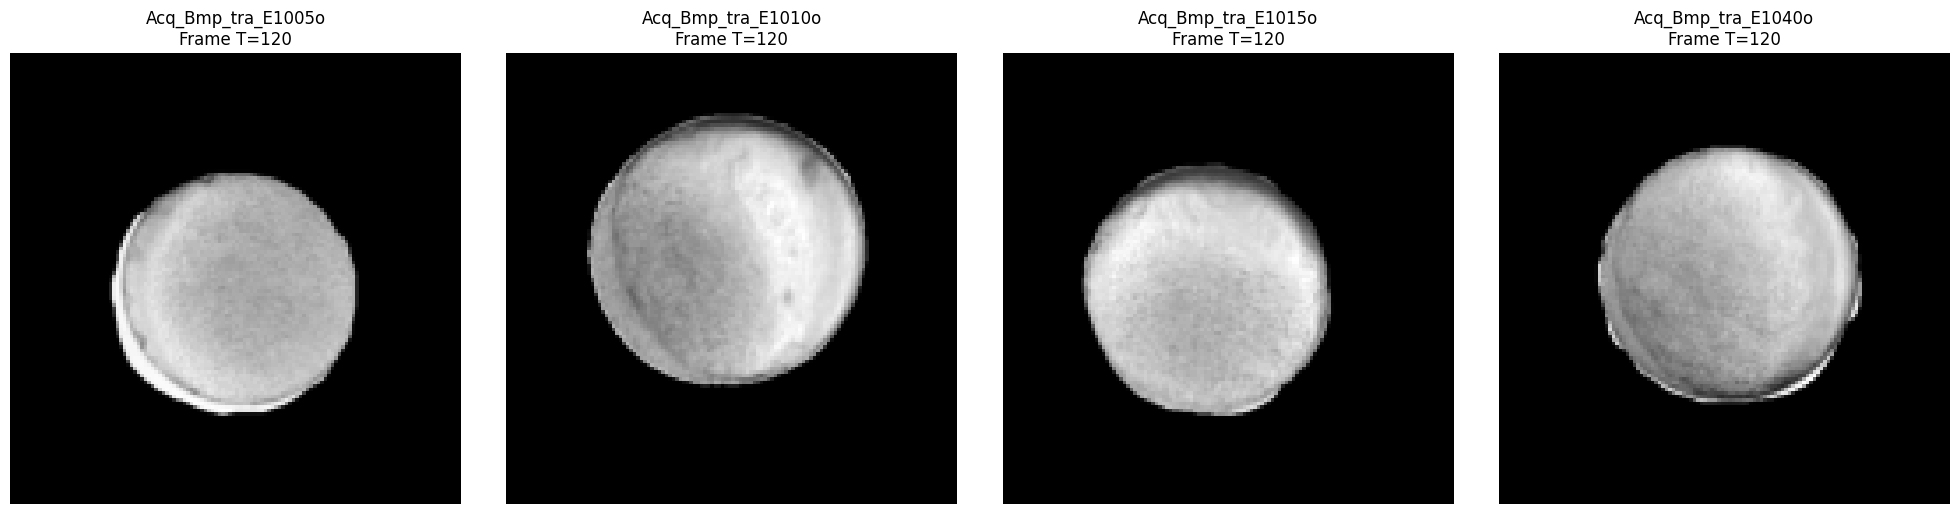

In [9]:
# VISUALIZATION
OUTPUT_TRAIN_DIR = os.path.join(BASE_PATH, 'train/masked_images')
NUM_SAMPLES = 4
FRAME_TO_PLOT = 120

# Find the first 20 files
search_path = os.path.join(OUTPUT_TRAIN_DIR, 'masked_*.tif')
masked_files = sorted(glob.glob(search_path))[:NUM_SAMPLES]

if not masked_files:
    print("Error: No masked images found. Please ensure files were saved correctly.")
else:
    # Adjust figure size based on the actual number of samples
    plot_count = min(NUM_SAMPLES, len(masked_files))
    fig, axes = plt.subplots(1, plot_count, figsize=(5 * plot_count, 5))

    # Handle the case of only one image being plotted
    if plot_count == 1:
        axes = [axes]

    # Loop and Plot
    for i, file_path in enumerate(masked_files):

        image_volume = imread(file_path)
        print(f"Shape of the image volume: {image_volume.shape}")

        image_2d_slice = image_volume[FRAME_TO_PLOT, :, :]

        # Plot
        axes[i].imshow(image_2d_slice, cmap='gray') # Added cmap='gray' for clearer grayscale display

        # Set title
        original_name = os.path.basename(file_path).replace('masked_', '').split('.')[0]
        axes[i].set_title(f"{original_name}\nFrame T={FRAME_TO_PLOT}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

In [10]:
#One embryo selected to plot
# Map conditions to keywords in the filenames
CONDITIONS = {
    "WT": "Acq_Nor_tra_E1080o",
    "BMP": "Acq_Bmp_tra_E1005o",
    "Nodal": "Key_Nod_tra_E0105o"
}


In [11]:
# FIND EXAMPLE FILES PER CONDITION
masked_files = sorted(glob.glob(os.path.join(OUTPUT_TRAIN_DIR, "masked_*.tif")))

def find_example(masked_files, keyword):
    keyword = keyword.lower()
    for f in masked_files:
        if keyword in os.path.basename(f).lower():
            return f
    return None

example_paths = {}
for cond_name, kw in CONDITIONS.items():
    path = find_example(masked_files, kw)
    if path is None and len(masked_files) > 0:
        path = masked_files[0]
    example_paths[cond_name] = path

print("Example files used for Figure 1:")
for k, v in example_paths.items():
    print(f"  {k}: {v}")

Example files used for Figure 1:
  WT: /content/drive/MyDrive/DS_ML_MFFF/zfish/train/masked_images/masked_Acq_Nor_tra_E1080o.tif
  BMP: /content/drive/MyDrive/DS_ML_MFFF/zfish/train/masked_images/masked_Acq_Bmp_tra_E1005o.tif
  Nodal: /content/drive/MyDrive/DS_ML_MFFF/zfish/train/masked_images/masked_Key_Nod_tra_E0105o.tif


In [12]:
example_paths = {}
for cond_name, kw in CONDITIONS.items():
    path_masked = find_example(masked_files, kw)
    if path_masked:
        #Get the basename ('masked_Acq_Bmp_tra_E1005o.tif')
        base_name = os.path.basename(path_masked)

        # Remove the 'masked_'
        orig_name = base_name.replace("masked_", "")

        # Find mask name
        mask_name = orig_name.replace("o.tif", ".tif")

        example_paths[cond_name] = {
            'original': os.path.join(TRAIN_IMG_DIR, orig_name),
            'mask': os.path.join(TRAIN_MASK_DIR, mask_name),
            'processed': path_masked
        }

print("Matched files for plotting:")
for k, v in example_paths.items():
    print(f" {k}: {os.path.basename(v['processed'])}")

Matched files for plotting:
 WT: masked_Acq_Nor_tra_E1080o.tif
 BMP: masked_Acq_Bmp_tra_E1005o.tif
 Nodal: masked_Key_Nod_tra_E0105o.tif


In [13]:
save_path = "/content/drive/MyDrive/DS_ML_MFFF/zfish"
os.makedirs(save_path, exist_ok=True)

Successfully saved preprocessing steps figure to: /content/drive/MyDrive/DS_ML_MFFF/zfish/preprocessing_steps.svg


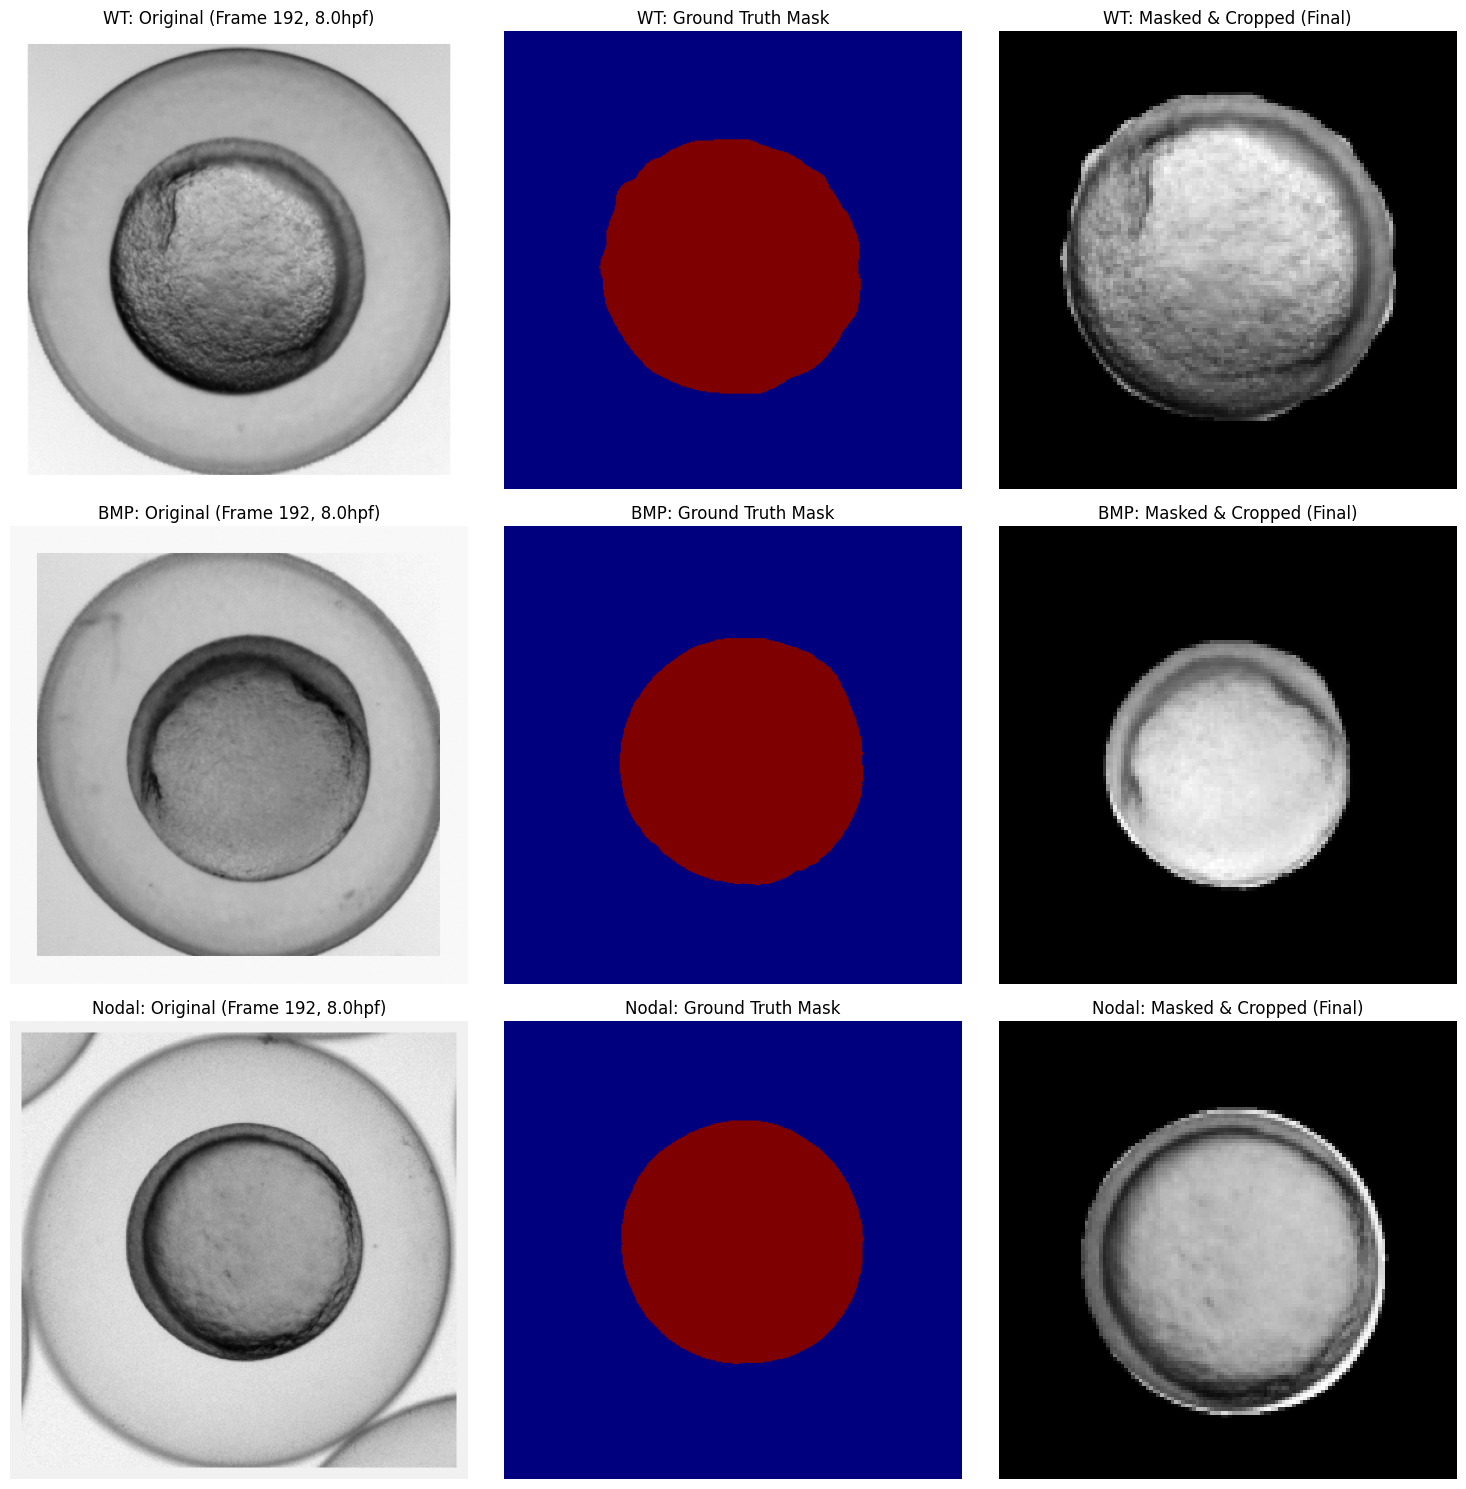

In [14]:
def plot_preprocessing_steps(example_dict, frame_idx=192):
    num_conditions = len(example_dict)
    fig, axes = plt.subplots(num_conditions, 3, figsize=(15, 5 * num_conditions))

    # Calculate hpf for the title
    hpf_val = 2 + (frame_idx * 14 / 449)

    for i, (cond, paths) in enumerate(example_dict.items()):
        # Load images
        img_orig = imread(paths['original'])[frame_idx]
        img_mask = imread(paths['mask'])[frame_idx]
        img_proc = imread(paths['processed'])[frame_idx]

        # Plotting
        axes[i, 0].imshow(img_orig, cmap='gray')
        axes[i, 0].set_title(f"{cond}: Original (Frame {frame_idx}, {hpf_val:.1f}hpf)")

        axes[i, 1].imshow(img_mask, cmap='jet')
        axes[i, 1].set_title(f"{cond}: Ground Truth Mask")

        axes[i, 2].imshow(img_proc, cmap='gray')
        axes[i, 2].set_title(f"{cond}: Masked & Cropped (Final)")

        for j in range(3):
            axes[i, j].axis('off')

    plt.tight_layout()

    #Save
    out_path_preproc = os.path.join(save_path, "preprocessing_steps.svg")
    plt.savefig(out_path_preproc, format='svg', bbox_inches='tight')

    print(f"Successfully saved preprocessing steps figure to: {out_path_preproc}")

    plt.show()

plot_preprocessing_steps(example_paths)

Grid figure saved to: /content/drive/MyDrive/DS_ML_MFFF/zfish/embryo_development_grid.svg


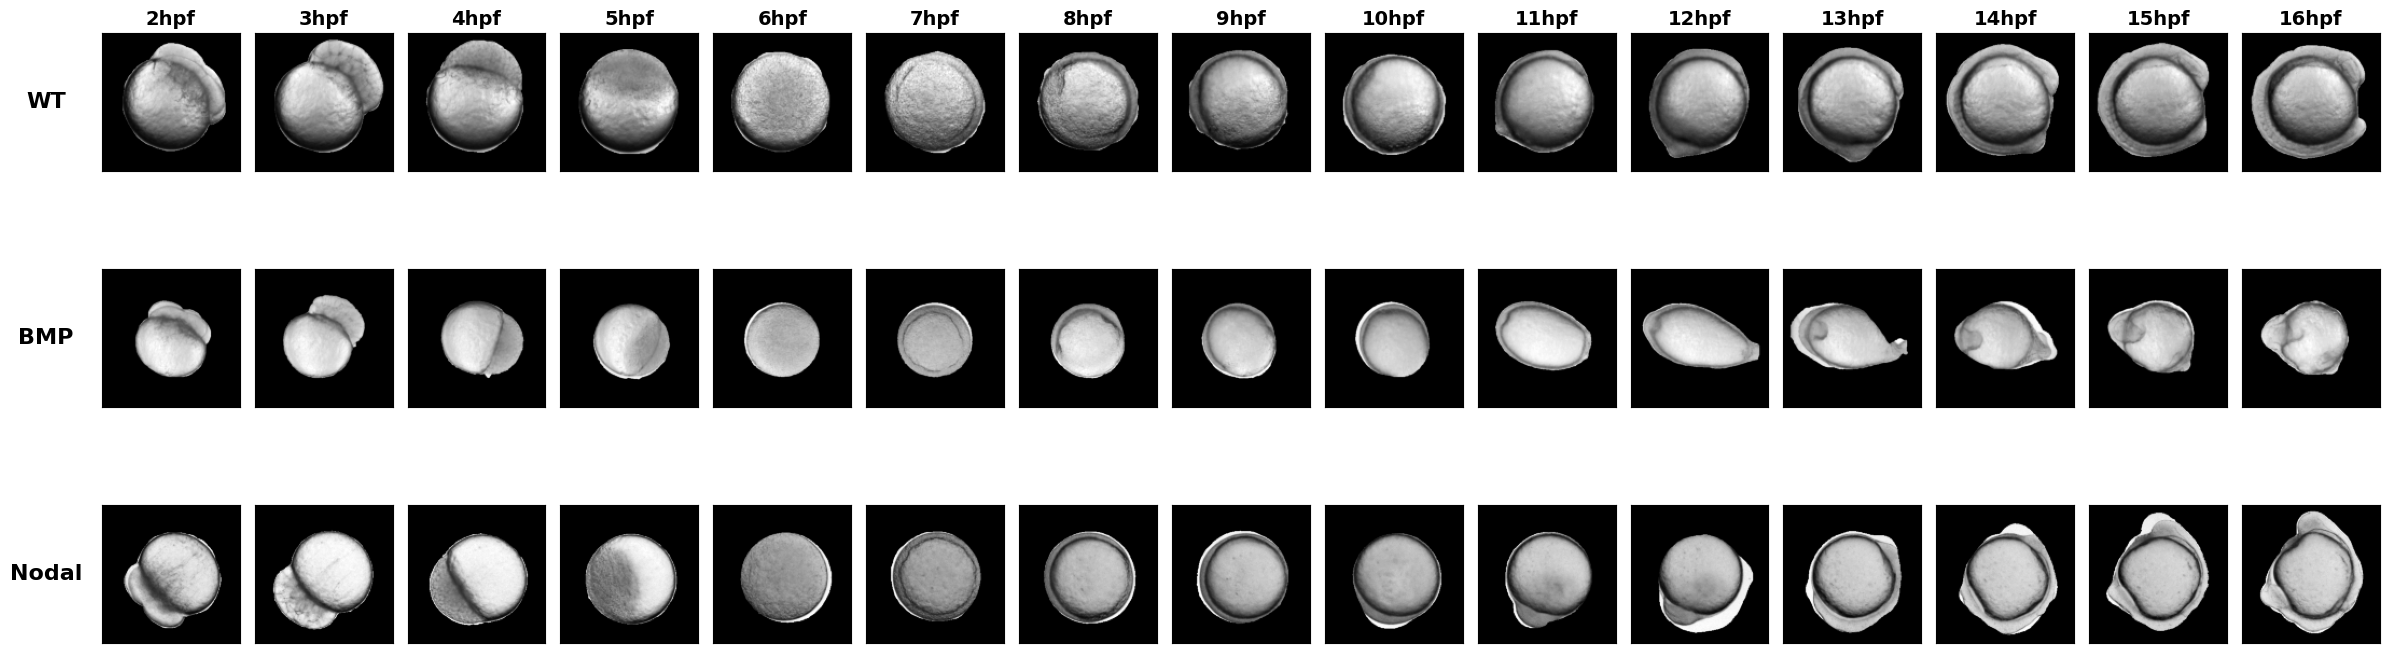

In [15]:
# Timepoints and mapping
hpf_timepoints = np.arange(2, 17)
conditions = ["WT", "BMP", "Nodal"]
total_frames = 450
total_hours = 14
frame_indices = [int(round((h - 2) * (total_frames - 1) / total_hours)) for h in hpf_timepoints]

# Setup Plot
fig, axes = plt.subplots(len(conditions), len(hpf_timepoints), figsize=(24, 8))

for row_idx, cond in enumerate(conditions):
    # FIX: Check if example_paths[cond] is a dict or a string
    path_data = example_paths.get(cond)

    if isinstance(path_data, dict):
        # If you ran the 3-part preprocessing code, the path is under 'processed'
        vol_path = path_data.get('processed')
    else:
        # If you ran the original code, the path is the string itself
        vol_path = path_data

    if vol_path and os.path.exists(str(vol_path)):
        vol = imread(vol_path)

        for col_idx, f_idx in enumerate(frame_indices):
            ax = axes[row_idx, col_idx]
            t = min(f_idx, vol.shape[0] - 1)
            img = vol[t]

            ax.imshow(img, cmap='gray')

            # Titles for the top row
            if row_idx == 0:
                ax.set_title(f"{hpf_timepoints[col_idx]}hpf", fontsize=14, fontweight='bold')

            # Label for the left side
            if col_idx == 0:
                ax.set_ylabel(cond, fontsize=16, fontweight='bold', rotation=0, labelpad=40, va='center')

            ax.set_xticks([])
            ax.set_yticks([])
    else:
        print(f"Warning: Could not find file for {cond} at {vol_path}")

plt.tight_layout()

# Export
save_file = os.path.join(save_path, "embryo_development_grid.svg")
plt.savefig(save_file, format='svg', bbox_inches="tight")
print(f"Grid figure saved to: {save_file}")

plt.show()

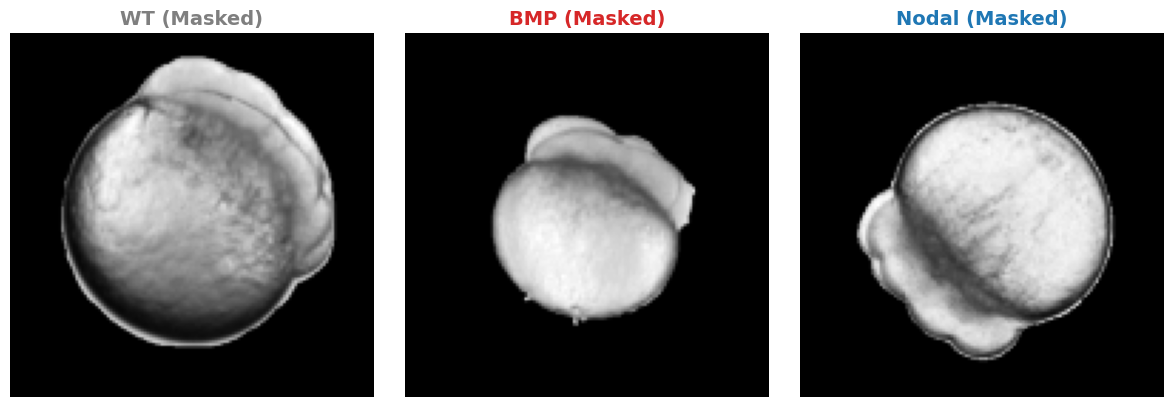

In [24]:
FRAME_TO_PLOT = 1
colors_dict = {"WT": "#7f7f7f", "BMP": "#d62728", "Nodal": "#1f77b4"}

# Create Figure
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for ax, cond in zip(axes, ["WT", "BMP", "Nodal"]):
    path_to_load = example_paths[cond]['processed']

    # Load the volume
    vol = imread(path_to_load)

    # Safety check for frame index
    t = FRAME_TO_PLOT if FRAME_TO_PLOT < vol.shape[0] else vol.shape[0] // 2
    img = vol[t]

    # Plotting
    ax.imshow(img, cmap='gray')
    ax.set_title(f"{cond} (Masked)", fontsize=14, fontweight='bold', color=colors_dict[cond])
    ax.axis('off')

fig.tight_layout()

# Standardized Exportation
os.makedirs(save_path, exist_ok=True)
save_file = os.path.join(save_path, "masked_embryo_development_grid.svg")

# Save using the fig object for reliability
fig.savefig(save_file, format='svg', bbox_inches="tight")

plt.show()

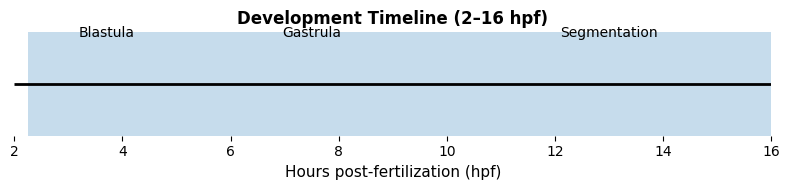

In [25]:
# 2–16 hpf timeline
figB, ax = plt.subplots(figsize=(8, 2))

ax.hlines(0, 2, 16, linewidth=2, color='black')

# Stage shading
ax.axvspan(2.25, 5.25, alpha=0.25)
ax.axvspan(5.25, 10.0, alpha=0.25)
ax.axvspan(10.0, 16.0, alpha=0.25)

ax.set_xlim(2, 16)
ax.set_xticks([2,4,6,8,10,12,14,16])
ax.set_yticks([])
ax.set_xlabel("Hours post-fertilization (hpf)", fontsize=11)
ax.set_title("Development Timeline (2–16 hpf)", fontsize=12, fontweight='bold')

# Stage labels
ax.text(3.7, 0.05, "Blastula", ha='center')
ax.text(7.5, 0.05, "Gastrula", ha='center')
ax.text(13.0, 0.05, "Segmentation", ha='center')

for spine in ax.spines.values():
    spine.set_visible(False)

figB.tight_layout()

# Export
figB.savefig(os.path.join(save_path, "timeline.svg"), bbox_inches="tight")


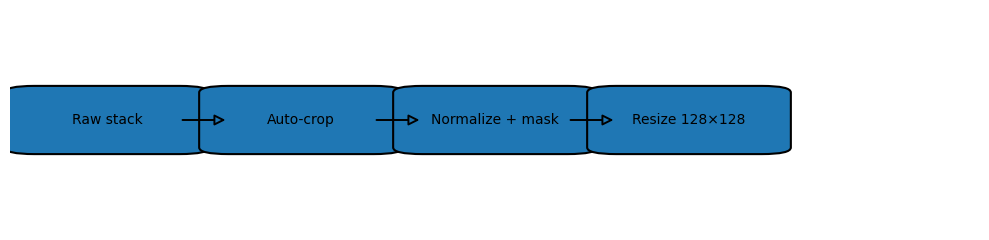

In [26]:
# Preprocessing Pipeline
steps = [
    "Raw stack",
    "Auto-crop",
    "Normalize + mask",
    "Resize 128×128"
]

figC, ax = plt.subplots(figsize=(10, 2.5))
ax.set_axis_off()

x_positions = [0.1, 0.3, 0.5, 0.7, 0.9]
y = 0.5
box_w, box_h = 0.15, 0.25

centers = []

# Draw boxes
for x, step in zip(x_positions, steps):
    centers.append((x, y))
    rect = FancyBboxPatch(
        (x - box_w/2, y - box_h/2),
        box_w, box_h,
        boxstyle="round,pad=0.03",
        linewidth=1.5,
        edgecolor="black"
    )
    ax.add_patch(rect)
    ax.text(x, y, step, ha='center', va='center', fontsize=10)

# Draw arrows
for i in range(len(centers) - 1):
    x1, y1 = centers[i]
    x2, y2 = centers[i+1]

    arrow = FancyArrowPatch(
        (x1 + box_w/2, y1),
        (x2 - box_w/2, y2),
        arrowstyle='-|>',
        mutation_scale=16,
        linewidth=1.4
    )
    ax.add_patch(arrow)

figC.tight_layout()

# Export
figC.savefig(os.path.join(save_path, "preprocessing.svg"), bbox_inches="tight")
